# Total Roll Call
This notebook covers a lot of the exploratory analysis on the roll call votes. Many of charts and graphs in the gallery concerning `missing votes` were generated here. Information about senators' records and election years can also be found here.

In [1]:
import pandas as pd 
import numpy as np

In [114]:
bills = pd.read_csv('../data/all_bills.csv', index_col=0)
senators = pd.read_csv('../data/senators114.csv', index_col=0)

In [115]:
bills = bills[['vote_number', 'vote_date', 'issue', 'title', 'yea', 'nay', 'result', 'question']]
bills['vote_number'].iloc[339:] = bills.iloc[339:, :].vote_number.apply(lambda x: x+339)

In [6]:
bills['vote_date'].iloc[339:] = bills['vote_date'].iloc[339:].apply(lambda x: str(x)+'-2016')
bills['vote_date'].iloc[:339] = bills['vote_date'].iloc[:339].apply(lambda x: str(x)+'-2015')

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
bills['vote_date'] = pd.to_datetime(bills['vote_date'])

#do questions
bills['question'] = bills.question.apply(lambda x: x.strip())
bills.question.value_counts()

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(style='ggplot')
plt.style.use(style='fivethirtyeight')

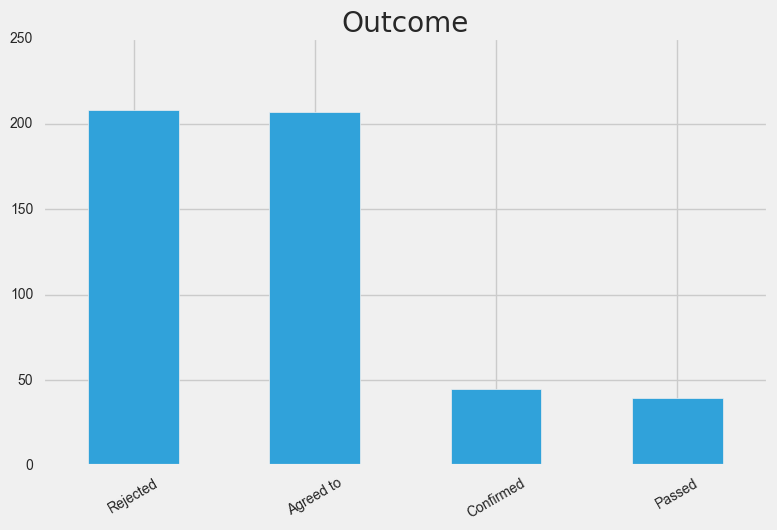

In [167]:
bills.result.value_counts()[:4].plot(kind='bar')
plt.title('Outcome')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('../gallery/outcomes.png')
plt.show()

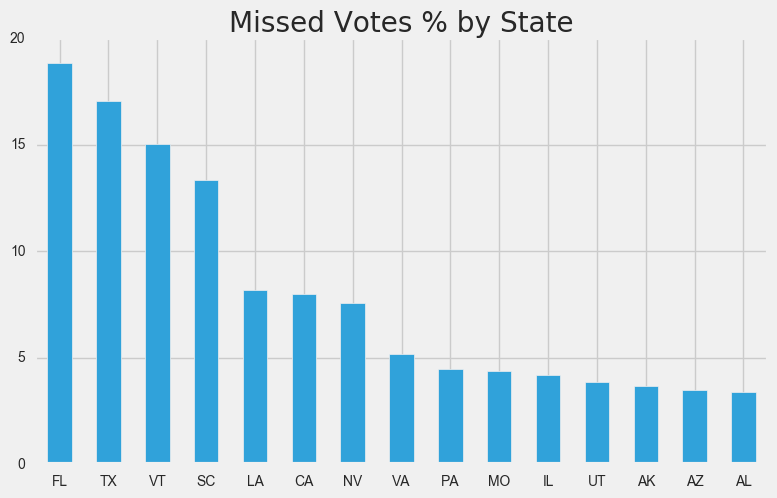

In [139]:
senators.pivot_table(index='state', values='missed_votes_pct').sort_values(ascending=False)[:15].plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Missed Votes % by State')
plt.tight_layout()
plt.xlabel('')
plt.savefig('../gallery/missed_votes_by_state.png')
plt.show()

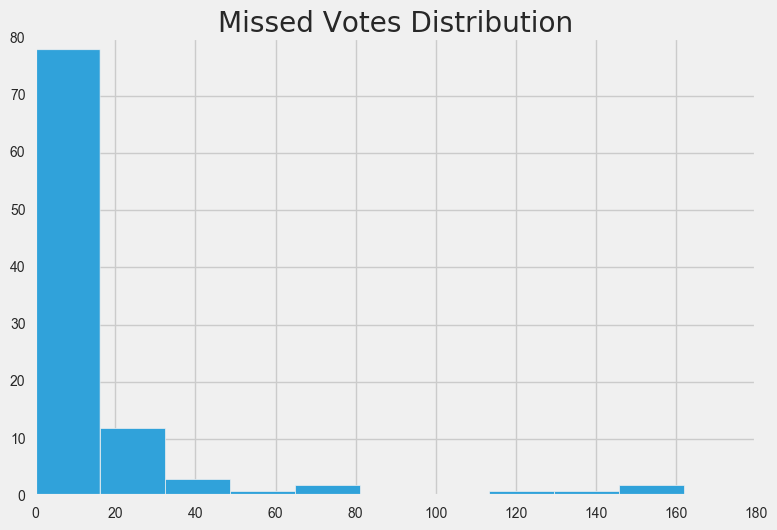

In [166]:
senators.missed_votes.plot(kind='hist')
plt.ylabel('')
plt.xlabel('')
plt.title('Missed Votes Distribution')
plt.tight_layout()
plt.savefig('../gallery/missed_hist.png')

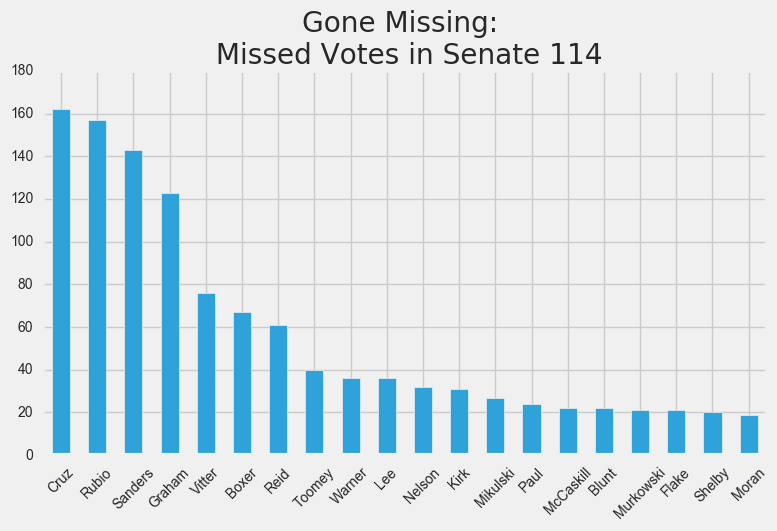

In [140]:
senators[['last_name', 'missed_votes']].sort_values(by='missed_votes', ascending=False)[:20].plot(kind='bar', x='last_name')
plt.xticks(rotation=45)
plt.title('Gone Missing: \n Missed Votes in Senate 114')
plt.legend('')
plt.xlabel('')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.savefig('../gallery/missed_votes_senators.png')
plt.show()

In [13]:
senators.head()

,lis_id,cspan_id,state,first_name,last_name,missed_votes,missed_votes_pct,next_election,party,senate_class,seniority,total_votes,votes_with_party_pct
0,S289,5,TN,Lamar,Alexander,14,2.79,2020,R,2,13,502,85.45
1,S340,95241,NH,Kelly,Ayotte,7,1.39,2016,R,3,5,502,79.39
2,S342,45465,MO,Roy,Blunt,22,4.38,2016,R,3,5,502,90.83
3,S223,2470,CA,Barbara,Boxer,67,13.35,2016,D,3,23,502,93.56
4,S307,5051,OH,Sherrod,Brown,11,2.19,2018,D,1,3,502,93.48


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

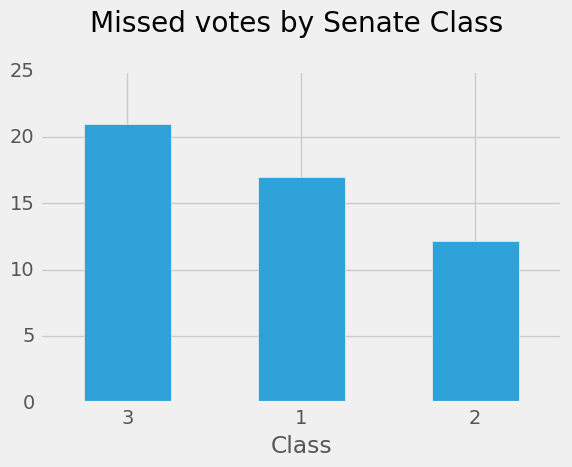

In [14]:
class_votes = senators.pivot_table(index='senate_class', values='missed_votes').sort_values(ascending=False)
class_votes.plot(kind='bar', title='Missed votes by Senate Class \n')
plt.xlabel('Class')
plt.xticks(rotation=0)

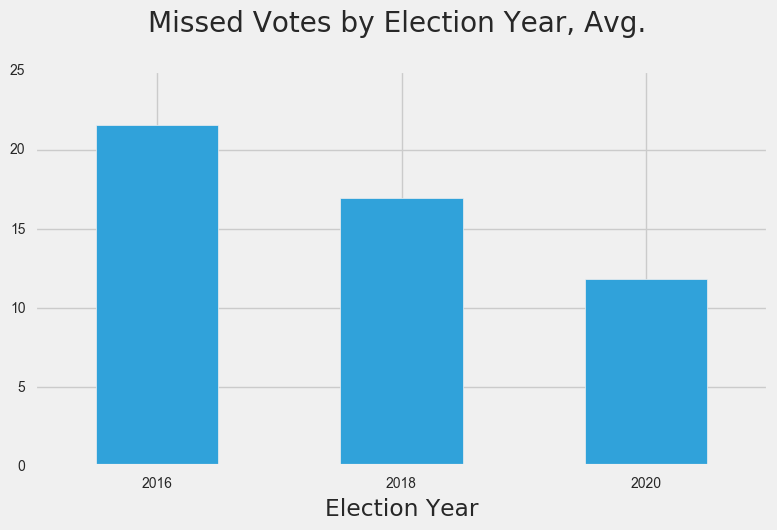

In [141]:
year_votes = senators.pivot_table(index='next_election', values='missed_votes').sort_values(ascending=False)
plt.style.use('fivethirtyeight')
year_votes.plot(kind='bar', title='Missed Votes by Election Year, Avg. \n')
plt.xlabel('Election Year')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../gallery/missed_votes_electionyear.png')
plt.show()

In [16]:
seniority_piv = senators.pivot_table(index='seniority', values='missed_votes_pct')

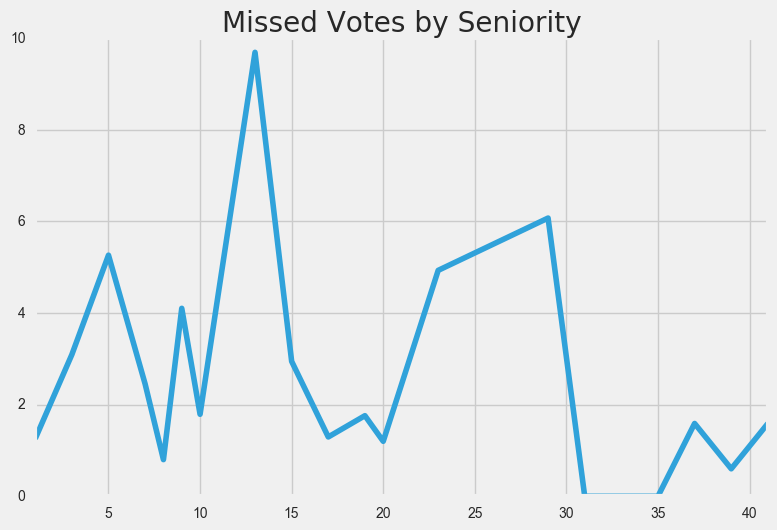

In [142]:
seniority_piv.plot()
plt.title('Missed Votes by Seniority')
plt.tight_layout()
plt.xlabel('')
plt.tight_layout()
plt.savefig('../gallery/missed_seniority.png')
plt.show()

In [18]:
#seniority distribution by party
import seaborn as sns

In [19]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( df[var].min() , df[ var ].max() ) )
    facet.add_legend()

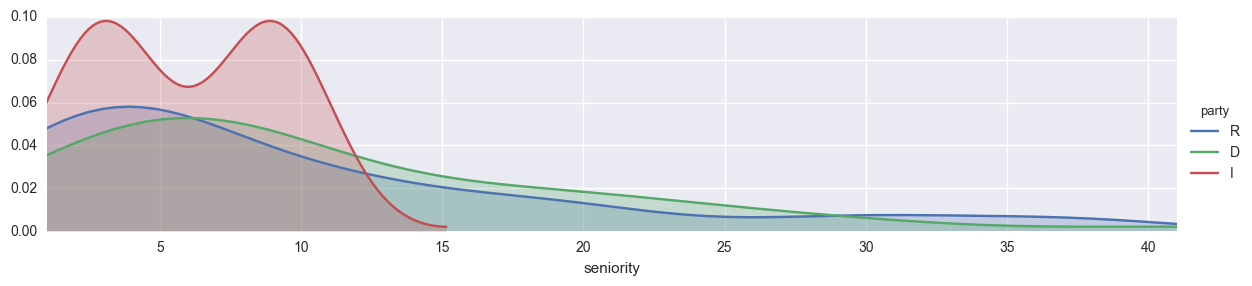

In [20]:
plot_distribution(senators, 'seniority','party')

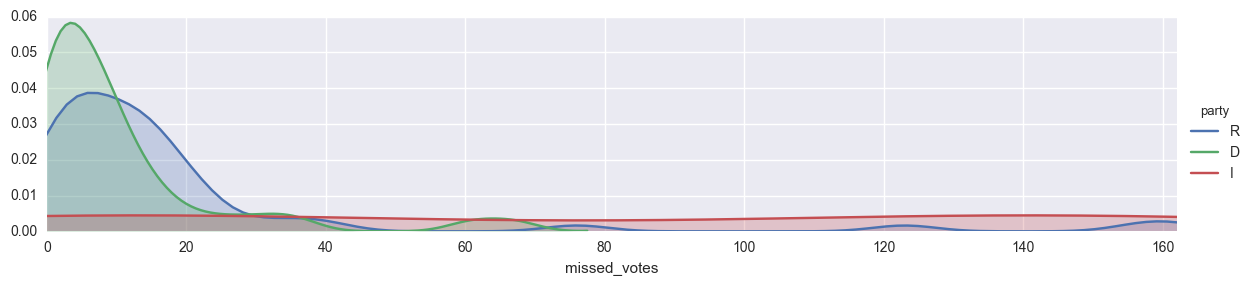

In [21]:
plot_distribution(senators, 'missed_votes', 'party')

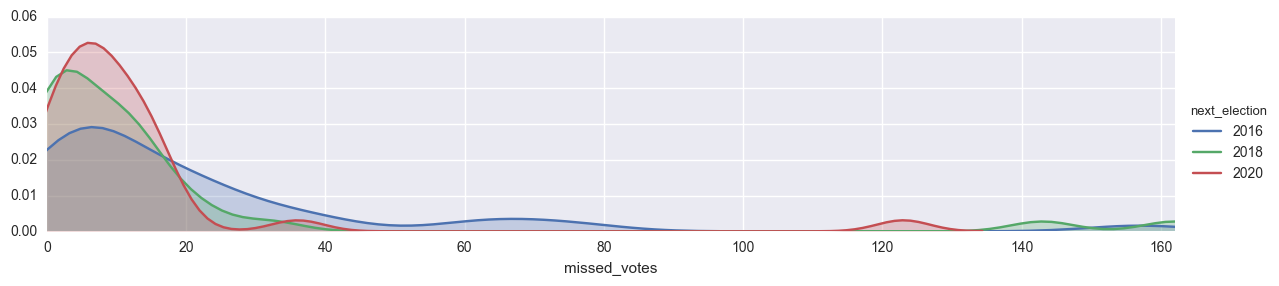

In [22]:
plot_distribution(senators, 'missed_votes', 'next_election')

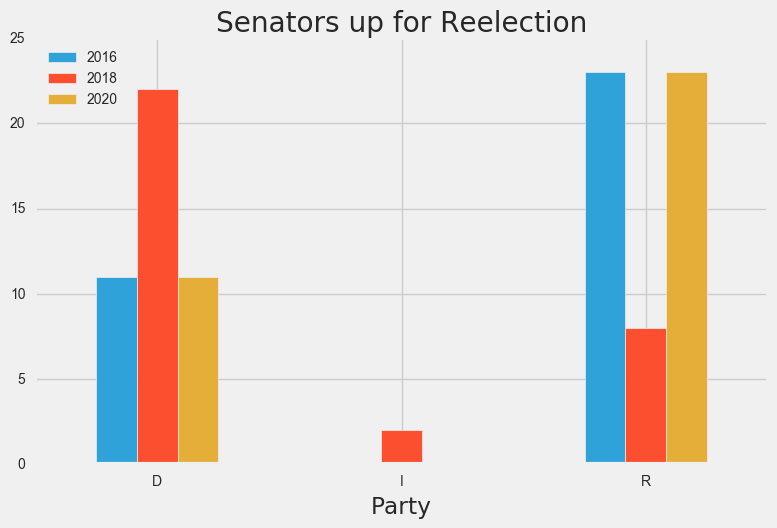

In [143]:
senators.groupby(['party', 'next_election']).size().unstack().plot(kind='bar', stacked=False)
plt.style.use('fivethirtyeight')
plt.legend(loc=0)
plt.title('Senators up for Reelection')
plt.xlabel('Party')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../gallery/up4reelection.png')

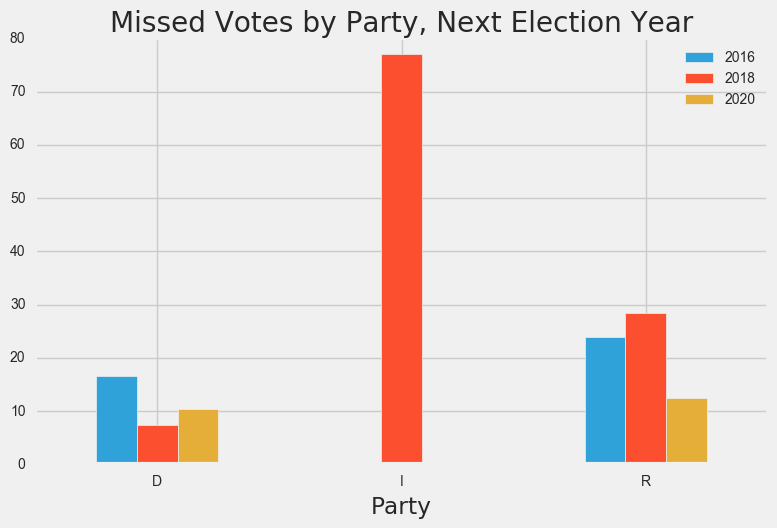

In [144]:
senators.groupby(['party', 'next_election'])['missed_votes'].mean().unstack().plot(kind='bar', stacked=False)
plt.legend(loc=0)
plt.title('Missed Votes by Party, Next Election Year')
plt.xlabel('Party')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../gallery/missed_votes_elec.png')

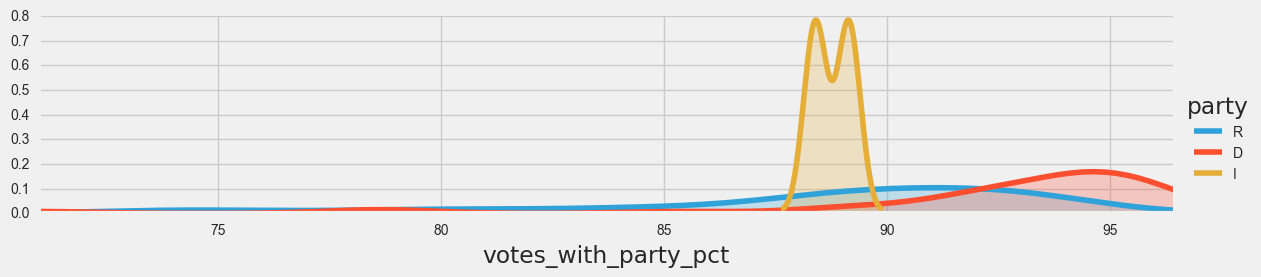

In [103]:
plot_distribution(senators, 'votes_with_party_pct', 'party')

In [106]:
senators.groupby('party')['votes_with_party_pct'].describe()

party       
D      count    44.000000
       mean     92.305455
       std       5.067455
       min      70.990000
       25%      91.810000
       50%      93.890000
       75%      95.077500
       max      96.410000
I      count     2.000000
       mean     88.765000
       std       0.530330
       min      88.390000
       25%      88.577500
       50%      88.765000
       75%      88.952500
       max      89.140000
R      count    54.000000
       mean     88.345370
       std       5.317825
       min      73.610000
       25%      87.227500
       50%      89.680000
       75%      92.250000
       max      94.420000
Name: votes_with_party_pct, dtype: float64

In [27]:
#the budget bill
bills[bills['issue'] == 'S.Con.Res. 11'].result.value_counts()

Agreed to    40
Rejected     29
Name: result, dtype: int64

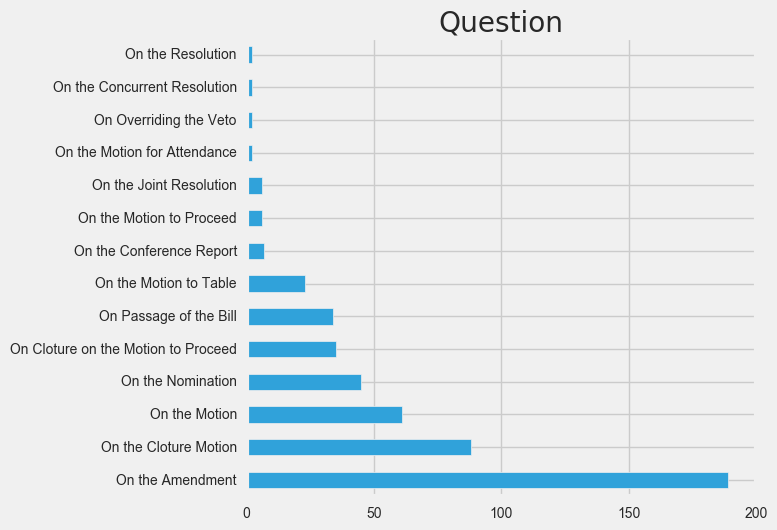

In [145]:
bills.question.value_counts().plot(kind='barh')
plt.title('Question')
plt.tight_layout()
plt.savefig('../gallery/questions_counted.png')
plt.show()

In [31]:
# find divisive bills
diffs = abs(bills.yea - bills.nay)

In [108]:
controversial_bills = diffs.sort_values()[:100].index.values

In [109]:
print (bills.iloc[controversial_bills-1, :].head(10).title.values)

[ "Motion to Waive Applicable Budgetary Discipline Bennet Amdt. No. 1115; To protect and retain our Children's Health Insurance Program for 4 years (PRO-CHIP)."
 'Motion to Waive All Applicable Budgetary Discipline Re: Shaheen Amdt. No. 3345; To make appropriations to address the heroin and opioid drug abuse epidemic for the fiscal year ending September 30, 2016.'
 'Motion to Invoke Cloture on the Motion to Concur in the House Amendment with an Amendment; A bill to reauthorize and amend the National Sea Grant College Program Act, and for other purposes.'
 'Gillibrand Amdt. No. 1578; To reform procedures for determinations to proceed to trial by court-martial for certain offenses under the Uniform Code of Military Justice.'
 'Coats Amdt. No. 3814; To limit the use of funds made available for the Advanced Technology Vehicles Manufacturing Loan Program.'
 'Motion to Waive Applicable Budgetary Discipline Cotton Amdt. No. 664; To establish a deficit-neutral reserve fund relating to construc

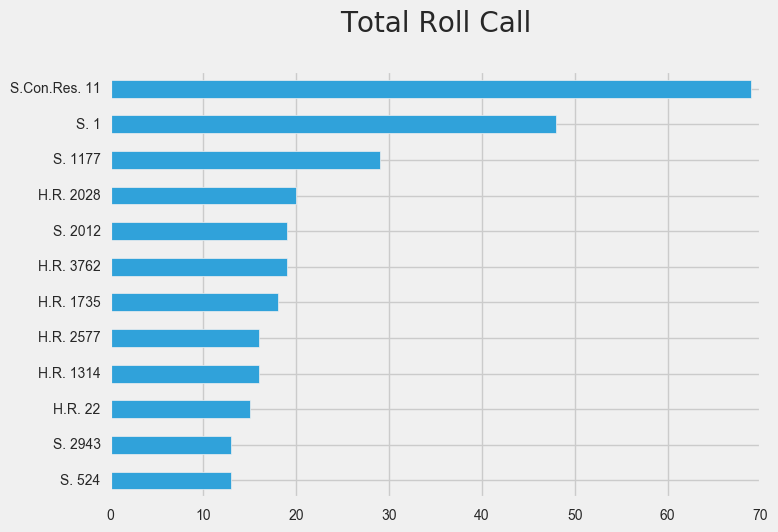

In [146]:
bills.issue.value_counts()[:12].sort_values().plot(kind='barh')
plt.title('Total Roll Call\n')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../gallery/rollcalls_issue.png')
plt.show()

In [37]:
top_3 = bills.issue.value_counts()[:3].index.values
top_3

array(['S.Con.Res. 11', 'S. 1', 'S. 1177'], dtype=object)

In [38]:
def get_top(bill):
    if bill in top_3: return True
    else: return False

In [39]:
idx = bills.issue.apply(get_top)

In [40]:
# the top 3 bills accounted for 41% of roll call votes

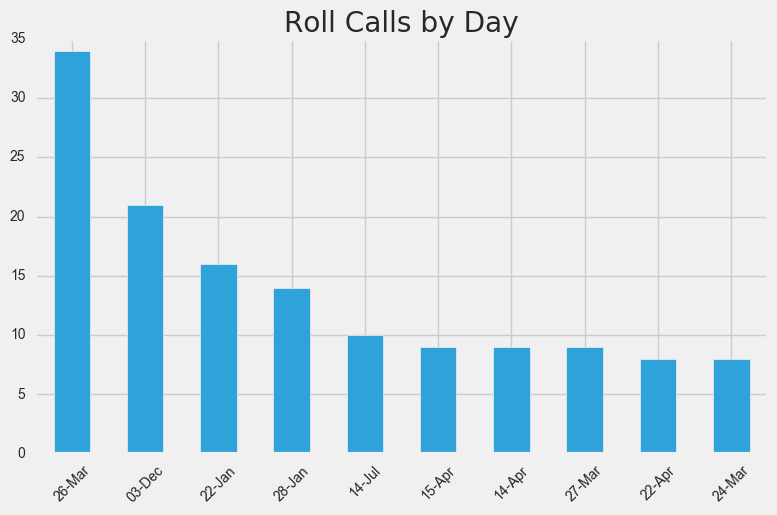

In [147]:
vals = bills.groupby('vote_date').size().sort_values(ascending=False)[:10]
labs = [str(x).split(' ')[0] for x in bills.groupby('vote_date').size().sort_values(ascending=False)[:10].index]
vals.plot(kind='bar')
plt.tight_layout()
plt.xticks(range(10), labs, rotation=45)
plt.xlabel('')
plt.title('Roll Calls by Day')
plt.savefig('../gallery/rollcalls_day.png')
plt.show()